### A new try at making ice sublimation or deposition fronts in a primordial porous pebble

Here I am using a diffusive approximation and the vapor pressure equal to partial pressure line to 
estimate the amoung of ice depositive by a water vapour rich front. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# constants, treated as global variables
#m_p = 1.67262192595E-27   # kg mass of proton in m
G = 6.67408E-11 #  × m3 kg-1 s-2
k_B = 1.3806503E-23 # m2 kg s-2 K-1 is also J K-1
AU = 1.5e11 # in m
R_gas = 8.314  # idea gas constant in J K-1 mol-1
N_A = 6.02214076E23 # Avogadro's number R_gas = k_B*N_A  is also molecules per mole-1 
sigma_SB = 5.670374419E-8 # W m−2 K−4.  # Stefan Boltzmann constant 
AMU = 1.66053906660E-27   # atomic mass unit in m 
m_u = AMU
hour = 60*60.0  # in s
Msol = 2e30 # kg
Rsol = 7e8 # m

# some typical values 
#rho_n = 1.0E-5 # kg/m^3 density of disk at 1AU , could up by a few? in shock
#rho_A = 100.0 # kg/m3 # asteroid density (rather low?)
#K_T = 1e-1 # thermal conductivity asteroid stuff W m-1 K-1, like balsa wood 
#C_P = 1.0E3 # J kg−1 K−1 #specific heat of most stuff to order of mag
# number density in protosolar nebula is of order 10^21 m-3
# pressure in protosolar nebula is a few Pa

In [3]:
print(np.sqrt(G*Msol/Rsol**3))
print(k_B*1e4)
print(np.sqrt(G*Msol/Rsol))
R = 1e3; rho = 1e3
P = G*(4*np.pi/3 * rho)**2 * R**2
print(P)  # you get 1 Pa in about 1 km radius body -- neglecting factors on top of pressure 
T = 6000
barm = AMU*10
vt = np.sqrt(k_B*T/barm)
print(vt)

0.0006238262447777181
1.3806503e-19
436678.37134440267
1171.031632732844
2233.5358223869434


Vapor pressure of olivine Costa+17 (note 1 bar = $10^5$ Pa)
$$P_v(T)  = {\rm Pa\ } 10^5 \times 10^{6.9908 -22519.0/T}$$ 

Vapor pressure of water  August equation https://en.wikipedia.org/wiki/Vapour_pressure_of_water
\begin{align}
P_v(T) & = e^{20.386-5132.0/T} {\rm mmHg} \times \frac{133.3224 \ {\rm Pa}}{\rm mmHg}  \\
& = {\rm Pa\ } 10^{10.97843}  10^{- \frac{2228.8}{T}} 
\end{align}


In [4]:

# arrays of information about constituents
# requires globals:
#  AMU atomic mass unit in kg

class info():
    def __init__(self):
        self.klabels = ['hydrogen', 'water', 'rocky']  # constituents
        self.n_k = len(self.klabels)  # number of constituents in gas or/and solid phases 
        self.Ag_karr = np.array([2.0,18.0,35.0])  # molecular weights for materials when they are gas components A_gk (unit-less)
        self.beta_gkarr = np.array([1.7, 2.3, 2.3])  # specific heat correction factors (unit-less) beta_gk
        self.rho_skarr = np.array([1.0, 1.0e3, 3.0e3])  # density of solid versions (kg m-3)
        # vapor pressures Pv in form 10^(A - B/T) giving result in Pa
        self.Pv_fun0_karr = np.array([0.0,10.97843,11.9908]) # vapor pressure functions, A constant terms but for (Pa)
        self.Pv_fun1_karr = np.array([0.0, 2228.8, 22519]) # exponent B terms (K)
        self.Hsub_karr = np.array([0.0, 2840.0E3, 2E7])  # latent heats for sublimation/condensation J/kg
        self.Hsub_mol_karr = self.Hsub_karr*(self.Ag_karr*AMU)  # latent heat per molecule in J/molecule
        # Hsub: for water-ice sublimation https://en.wikipedia.org/wiki/Latent_heat 
        # Hsub: for rock see above calculation which is based on a number from Costa+17?

        # an effective specific heat per unit mass for solid materials 
        self.C_uni = 3E6  # units J m-3 K-1 universal value for the product of density and specific heat for solids  
        self.K_Tuni = 1.  # typical value for brick, concrete, glass, thermal conductivity in units of J/s m-1 K-1 
        # we will correct this one by porosity
        # note that if you take K_Tuni/C_uni you get units of m^2/s as expected 
        
        #self.eps_s = 1.0  # surface emissivity 
        #self.n0 = 4e21 # nebular density for the moment, initial value 
        #some initial nebular compositions and number densities  molecules /m^3 at surface 

        self.n_s_fracs = np.array([0.9,0.1,0.0]) 
        # these might be nebula partial fractions of pressure or number density
        
        self.n_skarr = self.rho_skarr/(self.Ag_karr*AMU)  # compute number density in solid components 

# make this a variable we can pass around 
cinfo = info()

print(cinfo.n_skarr)  # number densities in solid components 
print(cinfo.Hsub_mol_karr) # J/mol latent heats

[3.01107038e+26 3.34563376e+28 5.16183494e+28]
[0.00000000e+00 8.48867571e-20 1.16237735e-18]


In [5]:
# values near 1AU
P_n = 10.0 # in Pa
T_n = 170
print('n nebular {:.3e}'.format(P_n/(k_B*T_n)))  # checking n0


n nebular 4.261e+21


In [6]:
# to compute vapor pressure in Pa for gas constituent k 
# uses info arrays Pv_fun0_karr, Pv_fun1_karr and class structure cinfo (class info)
# T can be an array and is in Kelvin
def Pv(T,k,cinfo):
    Afun = cinfo.Pv_fun0_karr[k]
    Bfun = cinfo.Pv_fun1_karr[k]
    return np.power(10.0, Afun - Bfun/T)
    #vapor pressures Pv in form 10^(A - B/T) giving result in Pa, T in K

# for gas component, specific heat per molecule, in J per molecule for gas constituent k 
# uses info array beta_gkarr
def c_gk(T, k, cinfo):
    beta = cinfo.beta_gkarr[k]
    return 2.5*k_B*T*beta  # not currently used

def alpha_ice_kos(T):
    a1 = 2.36 # ±0.21 from Kossacki+2017
    a2= 139.34# ±1.94,
    a3 = 7.80 # ±2.30
    y = np.tanh(-a3*np.tan(np.pi*(T-a2)/(273-a2) - np.pi/2))/a1
    z  =  (1.0 -1/a1) + y
    return z
#This is clearly no good, it oscillates 

def alpha_ice(T):
    return 0.5

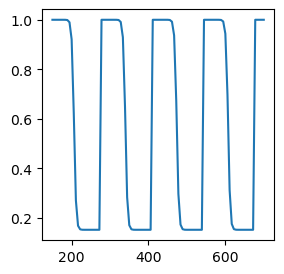

In [332]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
tarr = np.linspace(150,700,100)
alpha_s = alpha_ice_kos(tarr)
ax.plot(tarr,alpha_s)
plt.show()   # clearly bad!!!

In [7]:
# requires globals:
#   Pv(T,k,cinfo) routine to compute vapor pressures
#   alpha_ice(T) for alpha fudge factor in Hertz-Knudsen absoprtion equation 
#   class info() defined above 
#   k_B Boltzmann constant 

class heat_sim():
    def __init__(self,cinfo,dz,nz,porosity,rpore,T_init,Ttop,Ptop,n_s_fracs,dt,fv_ice_init=0):
        self.nk = cinfo.n_k 
        self.nz = nz  # grid size 
        self.dz = dz  # grid length
        self.zarr = np.arange(nz)*self.dz  # depth values 
        self.porosity = porosity  # porosity 
        self.rpore = rpore  # pore size 
        
        self.T_init = T_init  # equilibrium temperature prior to heating event 
        self.fv_ice_init = fv_ice_init # initial ice volume fraction 
        self.Ttop = Ttop # surface temperature 
        self.Ptop = Ptop
        self.n_s_fracs = n_s_fracs # array of initial surface number gas density fractions, should sum to 1 
        self.cinfo = cinfo  # information class info() contains info about solids and gasses 
        self.time = 0.0
        self.k_B = k_B   # make a local variable in case helps with speed 
        
        self.dt = dt # timestep 
        self.kappa = (1-self.porosity)*self.cinfo.K_Tuni/self.cinfo.C_uni  # diffusive T transport in solid only 

        # allocate arrays 
        self.Tarr  = np.zeros(nz) # array of temperatures 
        self.Pvarr = np.zeros((self.nk,self.nz)) # arrays of vapor pressures 
        self.narr  = np.zeros((self.nk,self.nz))  # arrays of number densities in gas constituents
        self.Parr  = np.zeros((self.nk,self.nz))  # arrays of partial pressures in gas 
        self.niarr = np.zeros((self.nk,self.nz))  # number of molecules per unit volume in solid phases 
        
        self.vtarr = np.zeros((self.nk,self.nz)) # arrays of thermal velocities for each gas consituent 
        
        self.dh = np.zeros(self.nz)  # heat generated per condensed or sublimated molecule in a timestep
        self.fv_ice = np.zeros((self.nk,self.nz)) # condensed ice volume fractions 

        # arrays for storage 
        self.nshow = 1
        self.nk_store   = np.zeros((self.nshow,self.nz))
        self.T_store    = np.zeros((self.nshow,self.nz))
        self.fice_store = np.zeros((self.nshow,self.nz))
        self.time_store = np.zeros(self.nshow)
        self.nint = 1 

        self.init_arrays() # initialize arrays 
        
    # initialize arrays or reset
    def init_arrays(self):
        self.time = 0.0
        self.Tarr[1:] = self.T_init # initialize internal temperature 
        self.Tarr[0] = self.Ttop  # surface value of temperature 
        self.load_Pv()  # load the Pvarr partial pressure arrays based on the initial temperature 
        self.load_vt()  # load thermal speed arrays 
        self.dh     *= 0.0
        self.fv_ice *= 0.0 
        self.niarr  *= 0.0
        if (self.fv_ice_init >0):
            self.fv_ice[1,:] = self.fv_ice_init
            self.niarr[1,:]  = self.fv_ice_init*self.cinfo.n_skarr[1] 

        for k in range(self.nk):  # set surface partial pressures 
            self.Parr[k,0] = self.Ptop*self.n_s_fracs[k] 
        # we set all constituents so their partial pressures are equal to their vapor pressure values except at the surface 
        # we adjust hydrogen so that gas pressure is equal everywhere to the surface one
        Ptotal = 0.0
        for k in range(1,self.nk):
            Pvmax= Pv(self.T_init,k,self.cinfo) # is a number, for initial cold interior temperature T_init 
            Pset = min(self.Ptop*self.n_s_fracs[k], Pvmax) # choose minimum of initial partial at surface or Pv
            self.Parr[k,1:] = Pset  # set everywhere but surface 
            Ptotal += Pset
        self.Parr[0,1:] = self.Ptop - Ptotal # initialize partial pressure array of hydrogen 
        for k in range(self.nk):  # initialize number density arrays 
            self.narr[k,:] = self.Parr[k,:]/(self.k_B * self.Tarr)

        if (self.Ttop > 400):  # zero out top ice in two grid positions 
            self.niarr[1,0:1] = 0 
        
    # solid heat transport only using universal values for diffusion coefficient kappa 
    # top-surface value in array is not changed 
    # Forward Time Centered Space Scheme
    def update_Tarr(self):  
        new_Tarr = np.zeros(self.nz)
        lap = (np.roll(self.Tarr,1) + np.roll(self.Tarr,-1) - 2*self.Tarr)*self.kappa*self.dt/self.dz**2  #Laplacian 
        lap[0] = 0  # kill the boundaries in the laplacian 
        lap[-1]= 0
        new_Tarr = self.Tarr + lap   # top value for temperature is not affected 
        new_Tarr[-1] = new_Tarr[-2]  # float the bottom boundary 
        #new_Tarr[0] = self.Ttop  # set top to be fixed, could be varied for a time dependent boundary condition 
        self.Tarr = new_Tarr # update temperature array 
        self.time += self.dt # update integration time 

    # compute vapor pressures of gas constituents in arrays 
    def load_Pv(self):  
        for k in range(1,self.nk):
            self.Pvarr[k,:] = Pv(self.Tarr,k,self.cinfo)  # calls external routine Pv, in Pa

    # compute thermal velocities of each molecule gas constituent in arrays, 
    def load_vt(self): 
        for k in range(self.nk):
            self.vtarr[k,:] = np.sqrt(8* self.k_B *self.Tarr/(np.pi*self.cinfo.Ag_karr[k] *AMU))
            # Ag_karr[k] *AMU is mass of molecule 

    # allow diffusion in the water vapor based on the gradient in its number density 
    # a fundamental problem is that the thermal timestep is much bigger than the diffusive one, 
    # so diffusion is done here with an adjustible timestep to make sure it it stable 
    # condensation/sublimation and heat are not taken into account in this routine 
    def diffuse(self):  # allow different gases to diffuse if there are variations in their number densities
        self.load_vt()  # compute thermal velocities - only varies with T
        self.load_Pv()  # update vapor pressure arrays - only varies with T 
        kTarr = self.k_B*self.Tarr   #k_B T array
        self.dh *= 0  # zero out the heat array 

        #Things that don't depend on number densities, only on temperature 
        k=1 # water
        Pvk = np.squeeze(self.Pvarr[k,:])  # vapor pressure 
        nvk = Pvk/kTarr        # number density of vapor pressure 
        vtk = np.squeeze(self.vtarr[k,:])  # thermal velocity 
        dif_cof = vtk * self.rpore/3  # compute Knudsen diffusion coefficient 
        max_dif_cof = max(dif_cof)  # maximum value (hottest region)
        dfac = 3  # must be >2 for stability of scheme
        dif_dt = self.dz**2/max_dif_cof/dfac  # choose a stable value for timestep 
        ndt = max(int(self.dt/dif_dt),1)  # divide the timestep into intervals 
        dif_dt = self.dt/ndt  # choose our timestep
        afac = dif_cof*dif_dt/self.dz**2  # is a vector for use in time loop 

        #Pk  = np.squeeze(self.Parr[k,:])   # partial pressure
        nk  = np.squeeze(self.narr[k,:])   # number density of gas pressure 
        nik = np.squeeze(self.niarr[k,:])  # number density of solid phase 

        alpha_ice_s = alpha_ice(self.Tarr)
        
        #print('ndt = ',ndt)

        # diffuse and condense/sublimation together, mutliple small steps 
        for j in range(ndt):  
            new_nk  = np.copy(nk)  # new gas phase number density 
            new_nik = np.copy(nik)  # new ice number density 

            # diffusion of number density of vapor
            lap = (np.roll(new_nk,1) + np.roll(new_nk,-1) - 2*new_nk)*afac  #Laplacian 
            lap[0] = 0  # kill the boundaries in the laplacian, top is Dirichlet and is not changed
            lap[-1]= 0
            new_nk+=lap
            new_nk[-1] = new_nk[-2]  # float bottom boundary 

            dnnv = (new_nk - nvk) #  is positive where we want to condense because Partial pressure>vapor pressure 
            tcond = (dnnv >0) # where condensation takes place 
            tsub = (dnnv <0)  # where sublimation can happen 

            # Knudsen absorption formula  to set evaporation rate 
            #https://en.wikipedia.org/wiki/Hertz%E2%80%93Knudsen_equation
            #https://www.sciencedirect.com/science/article/abs/pii/S0019103514000566
            # take dn and multiply by v_t, this gives a number per unit time, area, we want number per unit time, volume
            # so we divide by rpore 
            # the area of a pore is rpore^2, but there are (dz/rpore)^3 pores about in the volume dz^3 
            # so the number of pores times their area is dz^3/rpore 
            # so the absorption rate should be dnn * vt/rpore (at most) 
            # fudge factor here is the alpha that Kossacki measured and talks about in his comet studies 
            dn = alpha_ice_s*dnnv*vtk/(4*self.rpore) * dif_dt # total maximum change in number density due to condensation or evaporation 
            # check units mol/vol * m/s /m *s = mol/vol

            # condensation to at most the vapor pressure value if partial pressure exceeds vapor pressure 
            docond=1
            if (docond==1):
                dcond1 = np.logical_and ( (dnnv - dn >0 ), tcond)   # you can condense all of dn
                dcond2 = np.logical_and ( (dnnv - dn <0 ), tcond)   # you can condense down to vapor pressure 
                new_nk[dcond1]  -= dn[dcond1]  # remove condensed gas 
                new_nik[dcond1] += dn[dcond1]  # add it to the ice 
                self.dh[dcond1] += dn[dcond1]*self.cinfo.Hsub_mol_karr[k] # how much heat we gain from condensation 
                # Hsub_mol_karr is in units of J/molecule so dh is units of J/volume
                new_nk[dcond2]   = nvk[dcond2]   # gas is set to vapor pressure value 
                new_nik[dcond2] += dnnv[dcond2]  # whatever there was past vapor pressure add it to the ice 
                self.dh[dcond2] += dnnv[dcond2]*self.cinfo.Hsub_mol_karr[k]  # record heat gained from condensation 
                # dh has units of J/volume

            # sublimate ice if below vapor pressure and if there is ice 
            dosub=1
            if (dosub==1): # sublimation 
                dsub1 = np.logical_and( (nik - np.fabs(dn) >0), tsub) # you can sublimate, there is ice left over 
                dsub2 = np.logical_and( (nik - np.fabs(dn) <0), tsub) # you can sublimate all the ice present
                new_nik[dsub1]-= np.abs(dn[dsub1]) # remove ice 
                new_nk[dsub1] += np.abs(dn[dsub1])  # add sublimated ice to gas number density 
                self.dh[dsub1] -= np.abs(dn[dsub1])*self.cinfo.Hsub_mol_karr[k] # how much heat we loose from sublimation 
                new_nik[dsub2] = 0   # remove ice 
                new_nk[dsub2] += np.abs(nik[dsub2])  # add sublimated ice to gas number density 
                self.dh[dsub2] -= np.abs(nik[dsub2])*self.cinfo.Hsub_mol_karr[k] # how much heat we loose from sublimation 
                # dh has units of J/volume

            # updates within loop 
            nk = new_nk
            nik = new_nik
            
        # surface value of narr (number density of vapor) is not affected, neither is that of Parr (partial pressure)
        self.narr[k,1:]  = nk[1:] # update number density of  vapor 
        self.Parr[k,1:]  = nk[1:]*kTarr[1:]  # update partial pressure 
        self.niarr[k,:] = nik  # update number density of solid phase 
        self.fv_ice[k,:] = self.niarr[k,:]/self.cinfo.n_skarr[k]  # volume fraction of ice update 
        # n_skarr[k] is the number density of the solid form 
        
        addheat = 1 
        # take heat of sublimation/condensation and adjust temperature of solid 
        if (addheat==1):
            dT = self.porosity*self.dh/self.cinfo.C_uni  # note using C_uni!!!! is correct ! 
            Tnew  = self.Tarr + dT
            jj = (Tnew < self.T_init) # no refrigeration allowed (helps code stability?)
            self.Tarr[jj] += Tnew[jj]     # C_uni has units J m-3 K-1  Add the heat to the solid 
            # dh is supposed to have units of J/volume which means this should give a change in T
            # ignoring specific heat of the gas itself as it moves through the porous medium 

    # run nshow*nint time steps but only store nshow versions of some arrays 
    def run_save(self,nshow,nint):  
        self.nk_store   = np.zeros((nshow,self.nz))  # allocate space 
        self.T_store    = np.zeros((nshow,self.nz))
        self.fice_store = np.zeros((nshow,self.nz))
        self.time_store = np.zeros(nshow)
        for m in range(nshow):  # number of times to save 
            for j in range(nint):  # number of integration steps 
                self.update_Tarr()
                self.diffuse()
            k=1
            self.nk_store[m,:] = self.narr[k,:]
            self.fice_store[m,:] = self.fv_ice[k,:]
            self.T_store[m,:] = self.Tarr
            self.time_store[m] = self.time 
            
        print('time = {:.1f} s'.format(self.time))  
        self.nshow = nshow
        self.nint = nint 

    # similar to the previous routine but adding to the saved integration 
    def run_save_append(self,nshow_a,nint):
        # expand the arrays 
        expand_zeros = np.zeros((nshow_a,self.nz))    
        self.nk_store = np.append(self.nk_store,expand_zeros,axis=0)
        self.T_store  = np.append(self.T_store,expand_zeros,axis=0) 
        self.fice_store = np.append(self.fice_store,expand_zeros,axis=0)
        expand_zeros1 = np.zeros(nshow_a)
        self.time_store = np.append(self.time_store, expand_zeros1)
        for m in range(self.nshow,self.nshow+nshow_a):  # number of times to save 
            for j in range(nint):  # number of integration steps 
                self.update_Tarr()
                self.diffuse()
            k=1
            self.nk_store[m,:] = self.narr[k,:]
            self.fice_store[m,:] = self.fv_ice[k,:]
            self.T_store[m,:] = self.Tarr
            self.time_store[m] = self.time 

        self.nshow += nshow_a
        print('time = {:.1f} s'.format(self.time))  

    # change or update surface temperature and partial pressures 
    def set_top(self,Ttop,Ptop):
        self.Ptop = Ptop
        self.Ttop = Ttop
        for k in range(self.nk):  # set surface partial pressures 
            self.Parr[k,0] = self.Ptop*self.n_s_fracs[k] 
        self.Tarr[0] = self.Ttop
        
        

In [8]:

    
# make a figure from stored simulation outputs watervapor/ice only
def just_fig(sim,ofile=''):
    colorlist = ['black','brown','violet','blue','green','gold','orange','red']
    nc = len(colorlist)
    lw = 1

    if (len(ofile)>3):
        fig,axarr = plt.subplots(4,1,figsize=(3.5,3),sharex=True,dpi=300)
    else:
        fig,axarr = plt.subplots(4,1,figsize=(3.5,3),sharex=True)
        
    plt.subplots_adjust(hspace=0, wspace=0,left=0.23,bottom=0.15, top=0.98,right=0.96)
    
    nshow = sim.T_store.shape[0]
    zarr = sim.zarr

    for m in range(nshow):
        nk = np.squeeze(sim.nk_store[m,:])
        Tarr = np.squeeze(sim.T_store[m,:])
        fice = np.squeeze(sim.fice_store[m,:])
        Pk = nk*k_B*Tarr
        #Pk = np.squeeze(sim.Parr[k,:])
        #Pvk = np.squeeze(sim.Pvarr[1,:])
        axarr[0].plot(zarr,np.log10(Pk),'-',color=colorlist[m%nc],lw=lw)
        axarr[0].set_ylabel('log p (Pa)')
        axarr[1].plot(zarr,fice,'-',color=colorlist[m%nc],lw=lw)
        axarr[1].set_ylabel('ice (%)')
        jj = fice>0
        axarr[2].plot(zarr[jj],np.log10(fice[jj]),'-',color=colorlist[m%nc],lw=lw)
        axarr[2].set_ylabel('log ice (%)')
        axarr[3].plot(zarr,Tarr,'-',color=colorlist[m%nc],lw=lw)
        axarr[3].set_ylabel('T (K)')
        axarr[3].set_xlabel('depth z (m)')
        
    if (len(ofile) >3):
        plt.savefig(ofile)
    plt.show()

In [13]:
dz = 0.002   # grid spacing in m 
nz = 30  # grid length
porosity = 0.5  # porosity, kept fixed 
rpore = 1e-4    # pore size in m 
T0 = 200  # initial interior temperature 
Ttop = 800 #K  surface temperature
Ptop = 100 # Pa  surface pressure 
kappa = (1-porosity)*cinfo.K_Tuni/cinfo.C_uni  # diffusion coefficient for heat 
dt = dz**2/kappa/4   # choose timestep for heating of solid medium 
print('dt = {:.2f} s, rpore = {:.1e} m, dz = {:.1e} m '.format(dt,rpore,dz))

n_s_fracs = np.array([0.9,0.1,0.0]) # volume number density fractions of nebular gas
junk1 = heat_sim(cinfo,dz,nz,porosity,rpore,T0,Ttop,Ptop,n_s_fracs,dt)

nshow=6; nint=10  # number of data sets to store, and number if integration steps between each one 
junk1.run_save(nshow,nint)  # run the integration 
#run_fig(junk1,6,4,ofile='')

dt = 6.00 s, rpore = 1.0e-04 m, dz = 2.0e-03 m 
time = 360.0 s


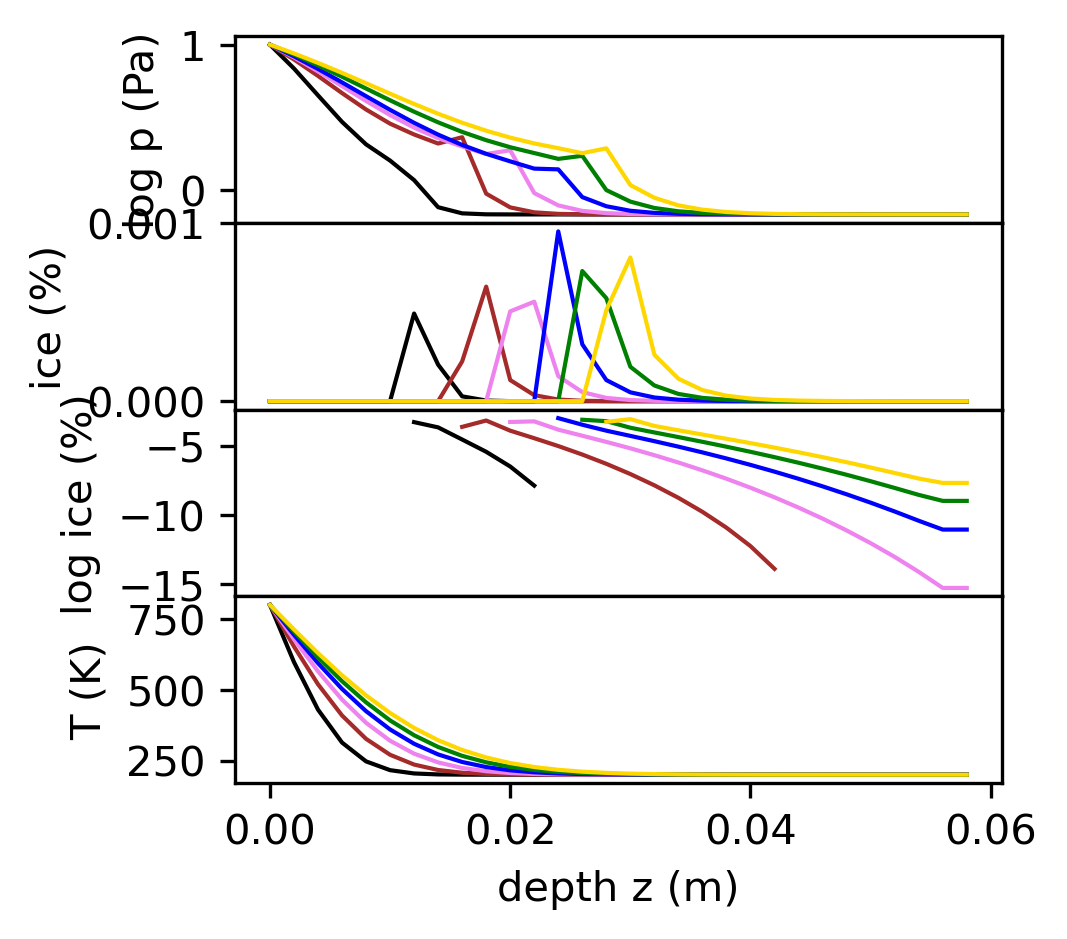

In [14]:
just_fig(junk1,'junk1.png')

In [15]:
nshow_a=6; nint=10
junk1.set_top(200,100) # reset surface temperature to something lower 
junk1.run_save_append(nshow_a,nint) # run some more timesteps 

time = 720.0 s


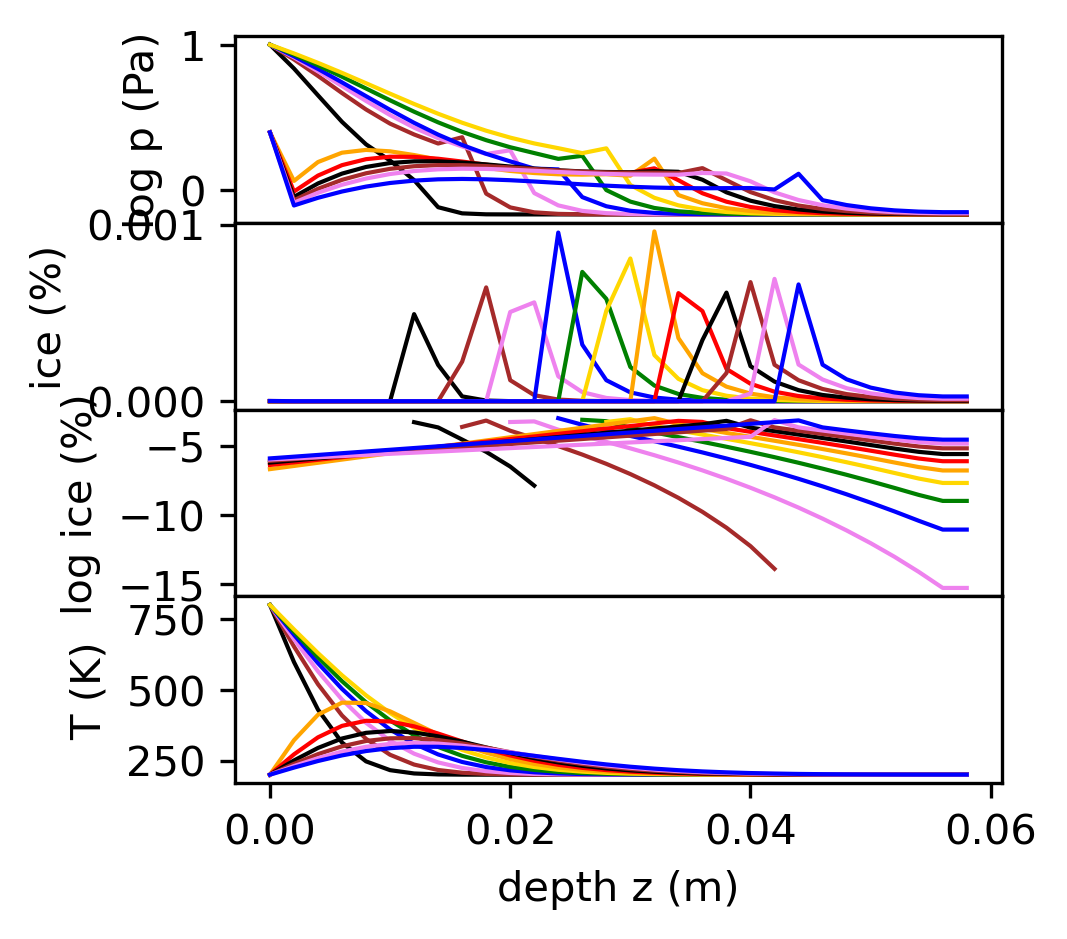

In [16]:
just_fig(junk1,'junk1b.png')

In [287]:
# test smaller grid, otherwise same parameters!
dz = 0.001 # 0.1 cm = 1mm 
nz = 60
porosity = 0.5
rpore = 1e-4   # 
T0 = 200
Ttop = 800 #K
Ptop = 100 # Pa
kappa = (1-porosity)*cinfo.K_Tuni/cinfo.C_uni
dt = dz**2/kappa/4   # timestep for heating of solid medium 
print('dt = {:.2f} s, rpore = {:.1e} m, dz = {:.1e} m '.format(dt,rpore,dz))

n_s_fracs = np.array([0.9,0.1,0.0]) # volume number density fractions of nebular gas
junk2 = heat_sim(cinfo,dz,nz,porosity,rpore,T0,Ttop,Ptop,n_s_fracs,dt)

nshow=6; nint=10*4
junk2.run_save(nshow,nint)


dt = 0.75 s, rpore = 1.0e-04 m, dz = 1.0e-03 m 
time = 360.0 s


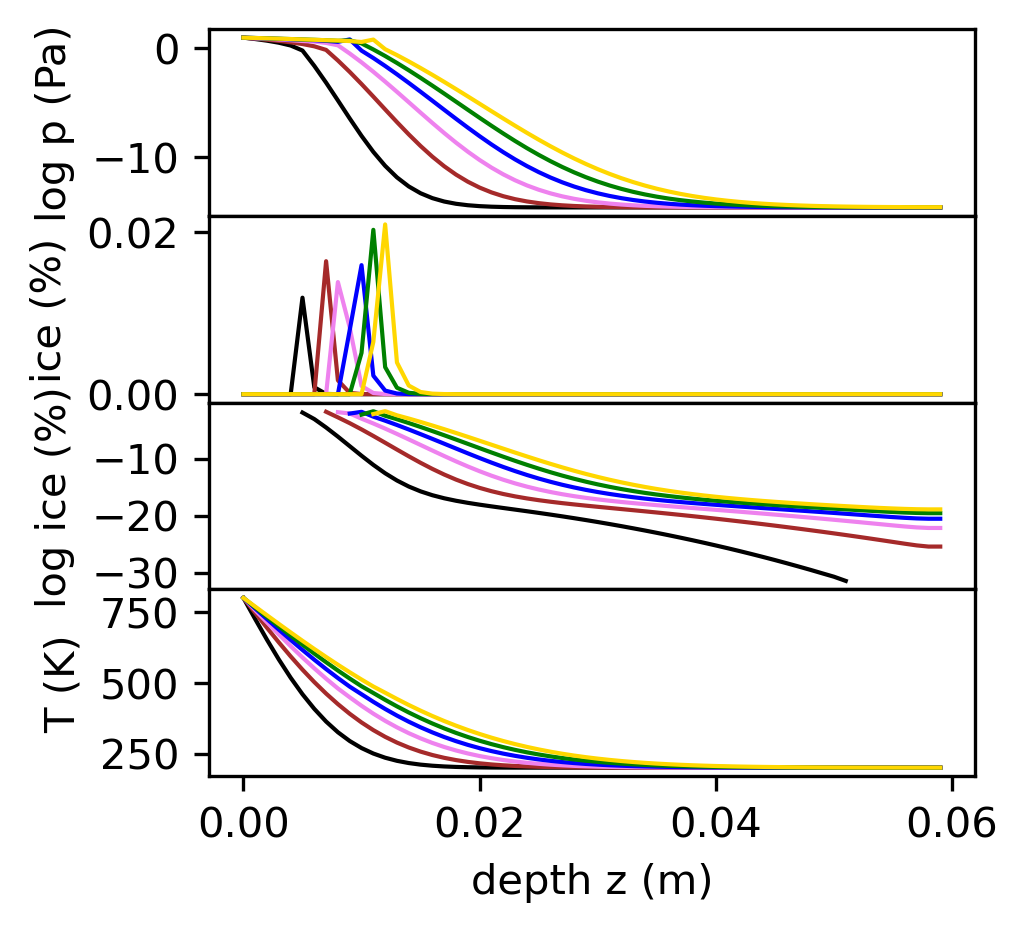

In [355]:
just_fig(junk2,'junk2.png')

In [341]:
# test initial icy body
dz = 0.002 # 
nz = 30
porosity = 0.5
rpore = 1e-4   # 
T0 = 200
Ttop = 800 #K
Ptop = 100 # Pa
kappa = (1-porosity)*cinfo.K_Tuni/cinfo.C_uni
dt = dz**2/kappa/100   # timestep for heating of solid medium 
print('dt = {:.2f} s, rpore = {:.1e} m, dz = {:.1e} m '.format(dt,rpore,dz))
fv_ice_init = 0.05

n_s_fracs = np.array([0.9,0.1,0.0]) # volume number density fractions of nebular gas
junk3 = heat_sim(cinfo,dz,nz,porosity,rpore,T0,Ttop,Ptop,n_s_fracs,dt,fv_ice_init = fv_ice_init)

nshow=8; nint=400
junk3.run_save(nshow,nint)


dt = 0.12 s, rpore = 1.0e-04 m, dz = 2.0e-03 m 
time = 384.0 s


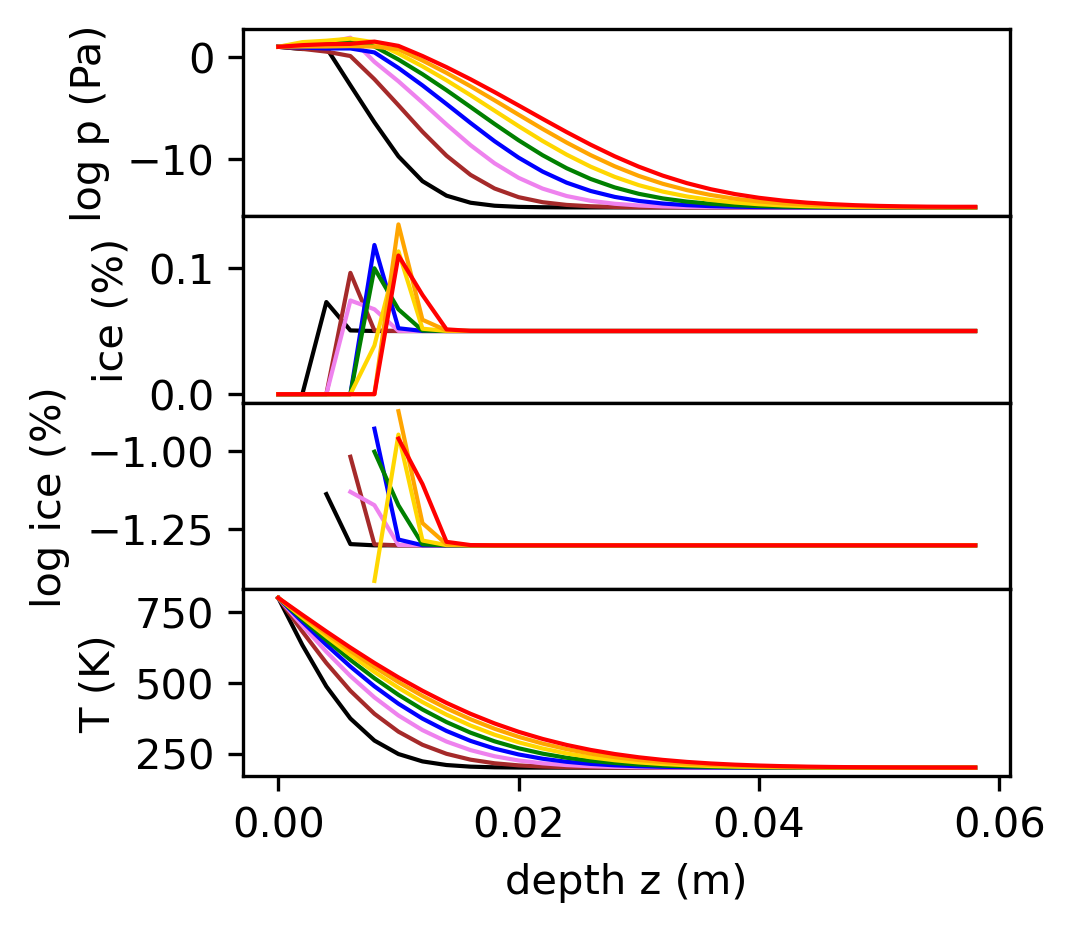

In [354]:
just_fig(junk3,'junk3.png')

### existing ice can probably push in as it sublimates
